# Autoencoder for Dimensionality Reduction of Histopathology Slides

Documentation of my progress and further implementions on building an autoencoder for dimensionality reduction of histopathology images. It starts with a roadmap and dives first into image formats and dataset preparation.

Author: terezajuricek <br>
Date: 2025-07-20 <br>
Project repo: histo_ae


In [5]:
import sys
print(sys.executable)

# !{sys.executable} -m pip install torchvision opencv-python scikit-learn matplotlib pandas pillow scikit-image albumentations

/usr/local/bin/python3


## 1. Define Project Roadmap and Requirements

Track steps and decisions. Code cells materialize these later.
- Division of steps
  - Data preparation and format validation (WSI vs. patches)
  - Preprocessing: tiling, tissue detection, normalization
  - Dataset persistence and manifest/splits
  - Input pipeline and loaders (streaming, prefetch)
  - Autoencoder scaffold (configurable latent)
  - Training loop + logging/metrics
  - Sanity checks and visualizations
- Constants (initial draft)
  - tile_size: 256 or 512
  - target_magnification: 20x (adjust based on scanner MPP)
  - overlap: 0.0–0.25
  - latent_dim: 64–256
  - normalization: none | Macenko | Reinhard
  - storage_format: WebDataset | Zarr | TFRecord
- Assumptions
  - Stain: H&E by default
  - Scanner types: Aperio (.svs) and/or Hamamatsu (.ndpi) possible
  - Hardware: single-GPU initially, CUDA available
  - No labels needed for training; optional for later tasks


10xVisium - [Targeted_Visium_Human_ColorectalCancer_GeneSignature](https://cf.10xgenomics.com/samples/spatial-exp/1.2.0/Targeted_Visium_Human_ColorectalCancer_GeneSignature/Targeted_Visium_Human_ColorectalCancer_GeneSignature_web_summary.html)

In [6]:
# Project checklist and initial config constants
from dataclasses import dataclass, asdict
from typing import Literal

milestones = {
    "ingestion": False,
    "preprocessing": False,
    "dataset_persistence": False,
    "input_pipeline": False,
    "autoencoder_scaffold": False,
    "training_loop": False,
    "sanity_checks": False,
}

@dataclass
class Config:
    tile_size: int = 256
    target_magnification: Literal[5, 10, 20, 40] = 20
    overlap: float = 0.1
    latent_dim: int = 128
    normalization: Literal["none", "Macenko", "Reinhard"] = "Macenko"
    storage_format: Literal["webdataset", "zarr", "tfrecord"] = "webdataset"

config = Config()
print("Milestones:", milestones)
print("Config:", asdict(config))

Milestones: {'ingestion': False, 'preprocessing': False, 'dataset_persistence': False, 'input_pipeline': False, 'autoencoder_scaffold': False, 'training_loop': False, 'sanity_checks': False}
Config: {'tile_size': 256, 'target_magnification': 20, 'overlap': 0.1, 'latent_dim': 128, 'normalization': 'Macenko', 'storage_format': 'webdataset'}


## 2. Set Up Environment and Dependencies

We’ll verify versions and availability of Python, CUDA, deep learning frameworks, and imaging libs. If missing, we’ll install and re-run.

Checklist:
- Python, CUDA, GPU availability
- torch or tensorflow presence
- openslide, pyvips, opencv, scikit-image, albumentations
- Deterministic seeding utilities


In [7]:
# Version checks and deterministic setup
import sys, platform, importlib, random, os
from datetime import datetime

print({
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "python": sys.version.split()[0],
    "platform": platform.platform(),
})

# Try deep learning frameworks
framework = None
try:
    import torch
    framework = "pytorch"
    print("torch:", torch.__version__)
    print("cuda_available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("gpu_name:", torch.cuda.get_device_name(0))
except Exception as e:
    print("torch not available:", e)

if framework is None:
    try:
        import tensorflow as tf
        framework = "tensorflow"
        print("tensorflow:", tf.__version__)
        print("gpu_available:", len(tf.config.list_physical_devices('GPU')) > 0)
    except Exception as e:
        print("tensorflow not available:", e)

# Imaging libs
for pkg in ["openslide", "pyvips", "cv2", "skimage", "albumentations", "PIL"]:
    try:
        m = importlib.import_module(pkg if pkg != "PIL" else "PIL.Image")
        ver = getattr(m, "__version__", getattr(m, "PILLOW_VERSION", "n/a"))
        print(f"{pkg}: {ver}")
    except Exception as e:
        print(f"{pkg} not available: {e}")

# Seeding
SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
try:
    import numpy as np
    np.random.seed(SEED)
    print("numpy:", np.__version__)
except Exception as e:
    print("numpy not available:", e)

if framework == "pytorch":
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif framework == "tensorflow":
    tf.random.set_seed(SEED)

print("Seeding complete.")

{'timestamp': '2025-08-13T13:08:58', 'python': '3.11.2', 'platform': 'macOS-15.1.1-arm64-arm-64bit'}
torch: 2.7.1
cuda_available: False
torch: 2.7.1
cuda_available: False
openslide not available: Couldn't locate OpenSlide dylib. Try `pip install openslide-bin`. https://openslide.org/api/python/#installing
pyvips not available: No module named 'pyvips'
openslide not available: Couldn't locate OpenSlide dylib. Try `pip install openslide-bin`. https://openslide.org/api/python/#installing
pyvips not available: No module named 'pyvips'
cv2: 4.12.0
skimage: 0.25.0
cv2: 4.12.0
skimage: 0.25.0
albumentations: 2.0.8
PIL: 10.4.0
numpy: 2.2.6
Seeding complete.
albumentations: 2.0.8
PIL: 10.4.0
numpy: 2.2.6
Seeding complete.


/Users/terezajurickova/Library/Python/3.11/lib/python/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>
  data = fetch_version_info()


## 3. Explore and Validate Image Formats (WSI vs. patch images)

Before modeling, confirm what we have:
- Whole Slide Images (WSIs): .svs, .ndpi, .mrxs, .tif(f), .scn, etc. Multi-resolution pyramids with magnification metadata (mpp).
- Pre-extracted patches: .png/.jpg/.tiff — typically single-resolution tiles.

Action items:
- List files and detect types by extension and by trying to open.
- For WSIs, read pyramid levels, downsample factors, and mpp.
- For patches, verify readability, color mode (RGB), and standardize size.

WSI readers: OpenSlide; alternative: tifffile for OME-TIFF. For speed and memory, prefer lazy reading of small regions (tiles) rather than loading whole slides.

## 4. Optional Pre-Conversion of WSIs to Interoperable Pyramidal TIFF

Proprietary formats can be fragile. Consider converting to pyramidal TIFF:
- Tools: pyvips (Python) or vips CLI; alternatively bioformats2raw + NGFF zarr for very large sets.
- Choose tile size (e.g., 256 or 512) and compression:
  - JPEG: smaller, faster IO, slight loss (often acceptable for autoencoder)
  - LZW/Deflate: lossless, larger
- Preserve metadata (mpp/pixel size) if available.
- Validate post-conversion by opening levels and sampling tiles.


In [8]:
# Format detection and basic metadata readers
import os, glob
from typing import List, Dict

WSI_EXTS = {".svs", ".tif", ".tiff", ".ndpi", ".mrxs", ".scn"}
PATCH_EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".webp"}

DATA_DIR = os.getenv("HISTO_DATA_DIR", "/path/to/data")  # TODO: set real path

paths = [
    *glob.glob(os.path.join(DATA_DIR, "**/*"), recursive=True)
]
files = [p for p in paths if os.path.isfile(p)]
print(f"Found {len(files)} files under {DATA_DIR}")

wsi_files, patch_files = [], []
for p in files:
    ext = os.path.splitext(p)[1].lower()
    if ext in WSI_EXTS:
        wsi_files.append(p)
    elif ext in PATCH_EXTS:
        patch_files.append(p)

print("WSIs:", len(wsi_files))
print("Patches:", len(patch_files))

# Read sample WSI metadata
try:
    import openslide
    if wsi_files:
        sample = wsi_files[0]
        slide = openslide.OpenSlide(sample)
        print("levels:", slide.level_count)
        print("level_dimensions:", slide.level_dimensions)
        print("level_downsamples:", slide.level_downsamples)
        mpp_x = slide.properties.get(openslide.PROPERTY_NAME_MPP_X)
        mpp_y = slide.properties.get(openslide.PROPERTY_NAME_MPP_Y)
        print("mpp:", mpp_x, mpp_y)
        # Sample a small region from level 0
        region = slide.read_region((0, 0), 0, (512, 512)).convert("RGB")
        print("sample_region_size:", region.size)
    else:
        print("No WSI files to sample.")
except Exception as e:
    print("OpenSlide error:", e)

# Read sample patch
try:
    from PIL import Image
    if patch_files:
        img = Image.open(patch_files[0]).convert("RGB")
        print("patch_size:", img.size)
    else:
        print("No patch files to sample.")
except Exception as e:
    print("PIL error:", e)

Found 0 files under /path/to/data
WSIs: 0
Patches: 0
OpenSlide error: Couldn't locate OpenSlide dylib. Try `pip install openslide-bin`. https://openslide.org/api/python/#installing
No patch files to sample.


## 📋 PRACTICAL GUIDE: Handling Pre-Extracted Patches

Since you have pre-extracted patches from WSI, let's create a systematic approach to validate, assess quality, and prepare them for the autoencoder.

### Phase 1: Discovery and Basic Validation
1. **Inventory your patches**: Count files, check extensions, estimate storage
2. **Sample validation**: Test readability, check dimensions and color channels
3. **Metadata extraction**: Infer patch size, naming convention, potential organization
4. **Quick quality check**: Detect obvious issues (corrupted files, wrong formats)

### Phase 2: Quality Assessment  
1. **Visual inspection**: Generate grids of random samples
2. **Technical metrics**: Blur detection, brightness/contrast distribution, tissue coverage
3. **Content analysis**: Background vs tissue ratio, stain quality
4. **Outlier detection**: Find patches that might need exclusion

### Phase 3: Dataset Preparation
1. **Standardization**: Resize if needed, ensure consistent format
2. **Organization**: Create train/val/test splits (patient-aware if metadata available)
3. **Preprocessing pipeline**: Normalization, augmentation strategy
4. **Efficient storage**: Convert to optimized format for training (WebDataset/HDF5/Zarr)

### Phase 4: Autoencoder Readiness Check
1. **Batch testing**: Verify dataloader works with sample batches
2. **Memory profiling**: Ensure your setup can handle the dataset size
3. **Baseline metrics**: Establish quality benchmarks before training

In [9]:
# PHASE 1: Patch Discovery and Basic Validation
import os
import glob
from pathlib import Path
from collections import defaultdict, Counter
import pandas as pd
from PIL import Image
import numpy as np

# 🔧 CONFIGURE YOUR PATCH DIRECTORY HERE
PATCH_DIR = input("Enter your patch directory path: ") if 'PATCH_DIR' not in globals() else PATCH_DIR
# Example: PATCH_DIR = "/Volumes/ExternalDrive/WSI_patches" or "/path/to/your/patches"

def discover_patches(patch_dir: str) -> dict:
    """Discover and catalog all patch files"""
    patch_dir = Path(patch_dir)
    
    if not patch_dir.exists():
        print(f"❌ Directory not found: {patch_dir}")
        return {}
    
    # Find all image files
    image_extensions = {'.png', '.jpg', '.jpeg', '.tiff', '.tif', '.bmp', '.webp'}
    all_files = []
    
    for ext in image_extensions:
        all_files.extend(patch_dir.rglob(f"*{ext}"))
        all_files.extend(patch_dir.rglob(f"*{ext.upper()}"))
    
    print(f"📊 Found {len(all_files)} potential patch files")
    
    # Analyze file structure
    stats = {
        'total_files': len(all_files),
        'extensions': Counter(f.suffix.lower() for f in all_files),
        'directory_structure': defaultdict(int),
        'file_sizes': [],
        'sample_files': all_files[:10] if all_files else []
    }
    
    # Analyze directory structure
    for f in all_files:
        relative_path = f.relative_to(patch_dir)
        depth = len(relative_path.parts) - 1  # subtract filename
        stats['directory_structure'][f"depth_{depth}"] += 1
    
    # Sample file sizes (first 100 files)
    for f in all_files[:100]:
        try:
            stats['file_sizes'].append(f.stat().st_size)
        except:
            pass
    
    return stats, all_files

# Run discovery
print("🔍 PHASE 1: Discovering patches...")
stats, patch_files = discover_patches(PATCH_DIR)

# Display results
print(f"\n📈 DISCOVERY RESULTS:")
print(f"Total files: {stats['total_files']:,}")
print(f"File extensions: {dict(stats['extensions'])}")
print(f"Directory structure: {dict(stats['directory_structure'])}")

if stats['file_sizes']:
    sizes_mb = [s/1024/1024 for s in stats['file_sizes']]
    print(f"Average file size: {np.mean(sizes_mb):.2f} MB")
    print(f"Total estimated size: {sum(sizes_mb) * len(patch_files) / len(stats['file_sizes']):.1f} MB")

print(f"\n📂 Sample files:")
for f in stats['sample_files']:
    print(f"  {f.name}")

# Store for next phases
PATCH_FILES = patch_files

🔍 PHASE 1: Discovering patches...
📊 Found 0 potential patch files

📈 DISCOVERY RESULTS:
Total files: 0
File extensions: {}
Directory structure: {}

📂 Sample files:


In [10]:
# PHASE 1B: Basic Patch Validation
def validate_patches(patch_files, max_samples=50):
    """Test patch readability and extract basic properties"""
    
    validation_results = {
        'readable': 0,
        'corrupted': 0,
        'dimensions': [],
        'channels': [],
        'modes': [],
        'corrupted_files': []
    }
    
    # Sample files for validation
    sample_files = patch_files[:max_samples] if len(patch_files) > max_samples else patch_files
    
    print(f"🧪 Testing {len(sample_files)} patches for basic validation...")
    
    for i, file_path in enumerate(sample_files):
        try:
            with Image.open(file_path) as img:
                # Basic properties
                validation_results['dimensions'].append(img.size)  # (width, height)
                validation_results['channels'].append(len(img.getbands()))
                validation_results['modes'].append(img.mode)
                validation_results['readable'] += 1
                
                # Quick test: convert to RGB (common requirement)
                img_rgb = img.convert('RGB')
                
        except Exception as e:
            validation_results['corrupted'] += 1
            validation_results['corrupted_files'].append((str(file_path), str(e)))
            print(f"❌ Corrupted: {file_path.name} - {e}")
    
    return validation_results

# Run validation
print("\n🔬 PHASE 1B: Validating patch readability...")
validation = validate_patches(PATCH_FILES)

# Analyze results
print(f"\n✅ VALIDATION RESULTS:")
print(f"Readable patches: {validation['readable']}")
print(f"Corrupted patches: {validation['corrupted']}")

if validation['dimensions']:
    dim_counter = Counter(validation['dimensions'])
    print(f"Most common dimensions: {dim_counter.most_common(3)}")
    
    channel_counter = Counter(validation['channels'])
    print(f"Channel counts: {dict(channel_counter)}")
    
    mode_counter = Counter(validation['modes'])
    print(f"Image modes: {dict(mode_counter)}")

# Check for consistency
unique_dims = set(validation['dimensions'])
if len(unique_dims) == 1:
    print(f"✅ All patches have consistent dimensions: {list(unique_dims)[0]}")
else:
    print(f"⚠️  Mixed dimensions found: {len(unique_dims)} different sizes")
    print(f"   Sizes: {sorted(unique_dims)}")

if validation['corrupted_files']:
    print(f"\n⚠️  Corrupted files found:")
    for file, error in validation['corrupted_files']:
        print(f"   {Path(file).name}: {error}")

# Store patch dimensions for later use
if validation['dimensions']:
    PATCH_HEIGHT, PATCH_WIDTH = validation['dimensions'][0]
    print(f"\n📏 Using patch size: {PATCH_WIDTH}x{PATCH_HEIGHT}")
else:
    print("❌ No valid patches found - check your directory path!")


🔬 PHASE 1B: Validating patch readability...
🧪 Testing 0 patches for basic validation...

✅ VALIDATION RESULTS:
Readable patches: 0
Corrupted patches: 0
⚠️  Mixed dimensions found: 0 different sizes
   Sizes: []
❌ No valid patches found - check your directory path!



🎯 PHASE 2: Quality assessment...
🔍 Analyzing quality of 0 patches...


/var/folders/93/m6hlq7n96p715h5cd3vq4psw0000gn/T/ipykernel_35283/559478030.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  axes[row, col].hist(metrics[key], bins=20, alpha=0.7, color=plt.cm.get_cmap(color)(0.7))
/Users/terezajurickova/Library/Python/3.11/lib/python/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/terezajurickova/Library/Python/3.11/lib/python/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/terezajurickova/Library/Python/3.11/lib/python/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/terezajur

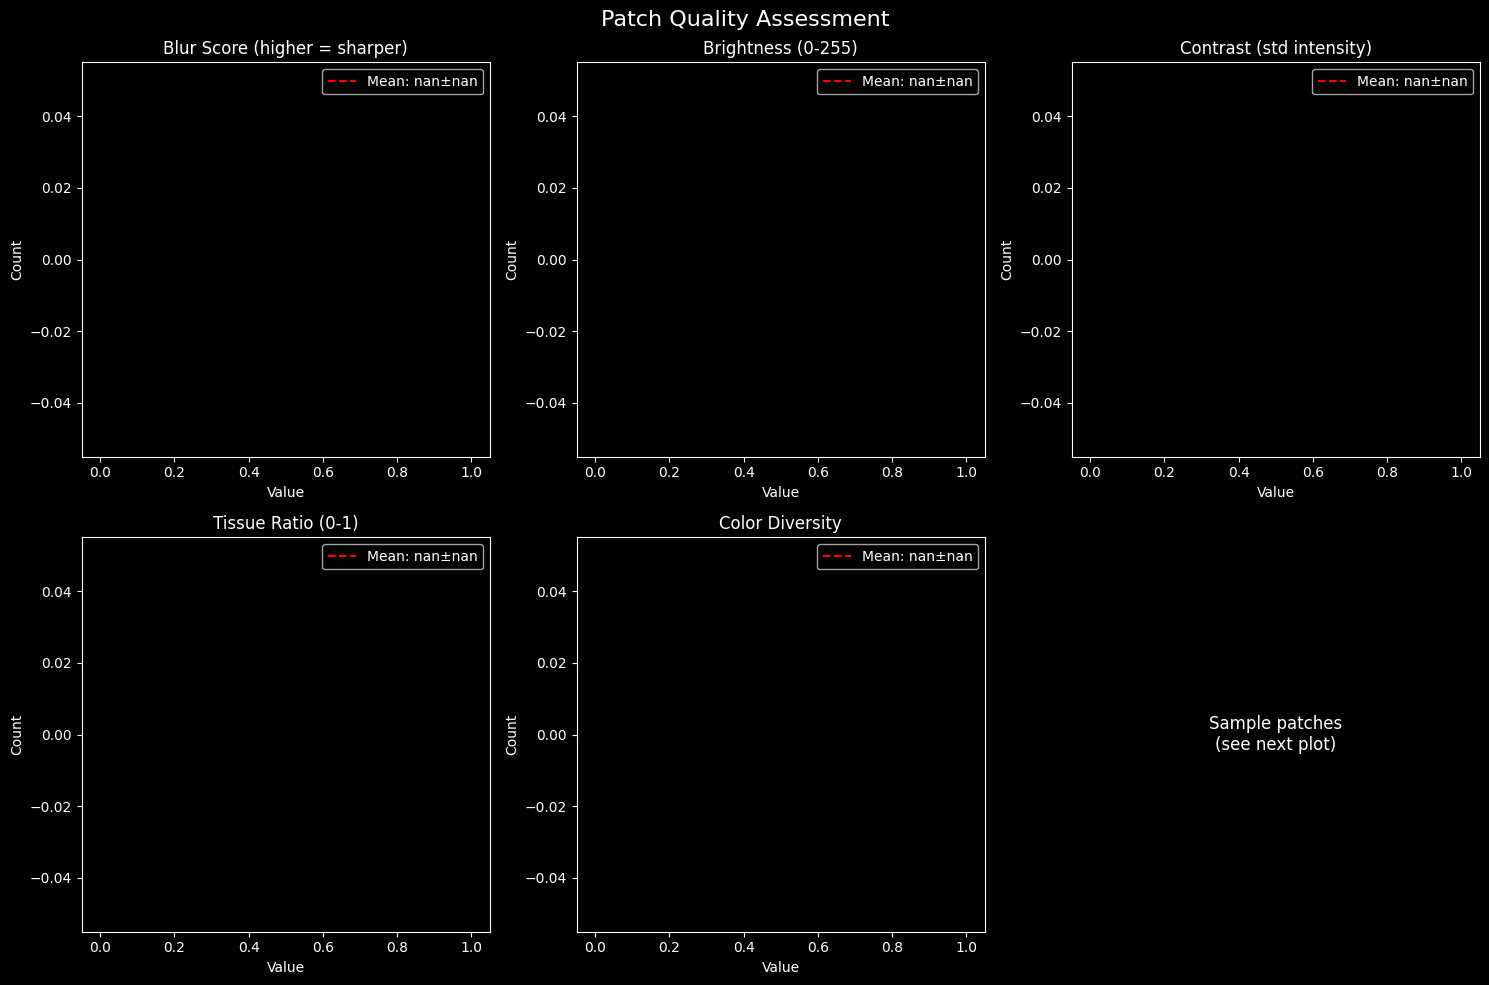

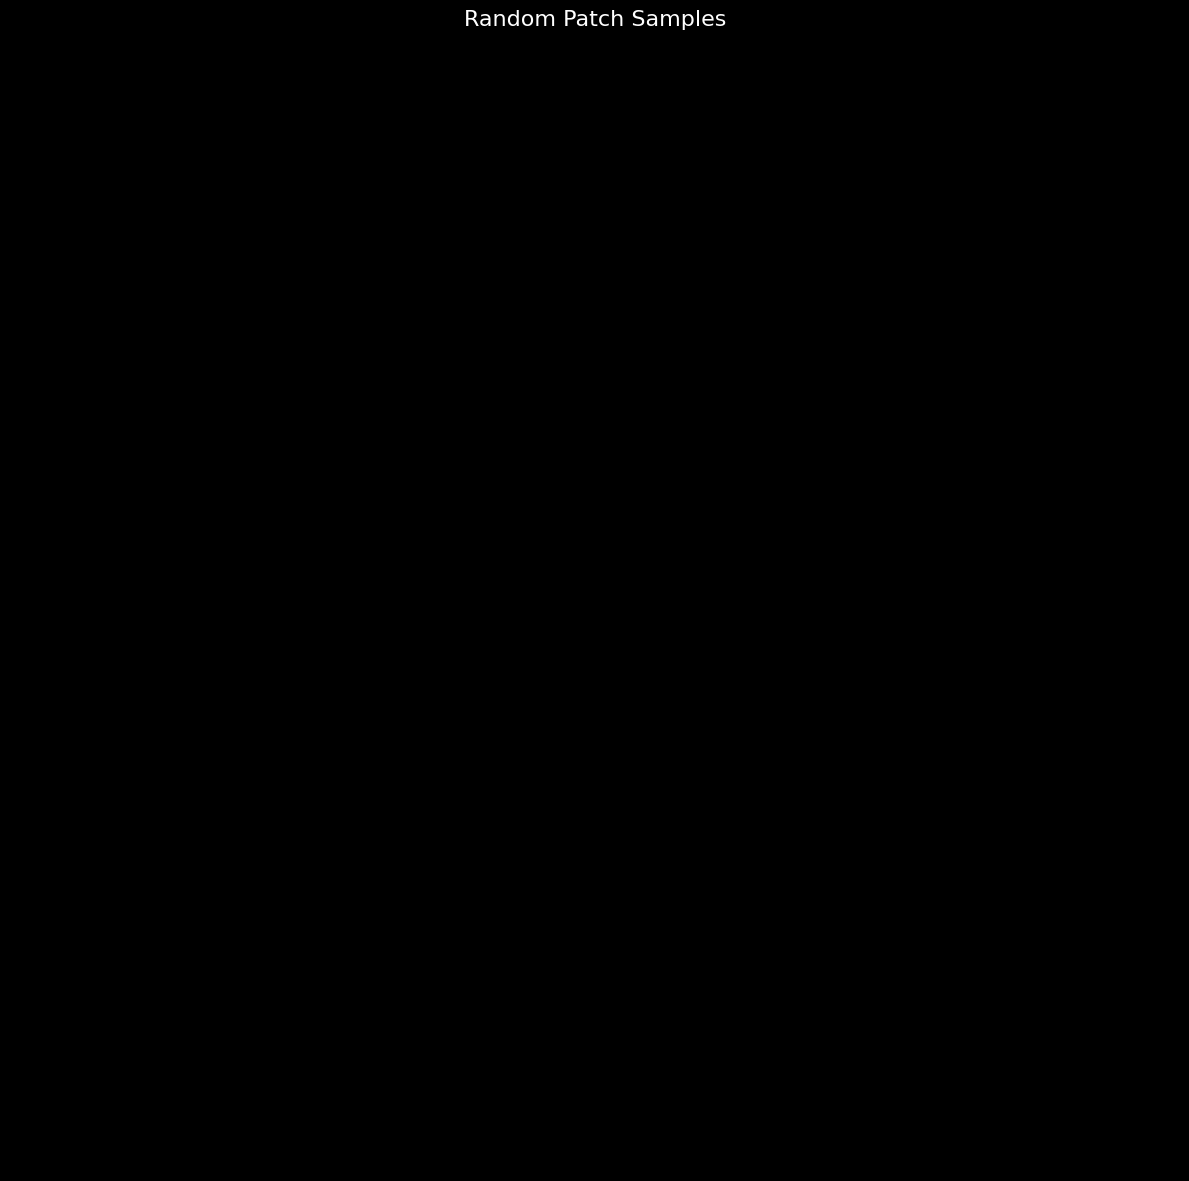


📊 QUALITY SUMMARY:
Blur scores - Mean: nan (>100 is good)
Brightness - Mean: nan (0-255 scale)
Contrast - Mean: nan (higher = more contrast)
Tissue ratio - Mean: nan (1.0 = all tissue)
Color diversity - Mean: nan (higher = more colorful)

⚠️  QUALITY FLAGS:
Potentially blurry patches: 0/0
Low tissue content patches: 0/0


In [11]:
# PHASE 2: Quality Assessment and Visual Inspection
import matplotlib.pyplot as plt
import cv2
from typing import List, Tuple

def assess_patch_quality(patch_files: List, n_samples: int = 25) -> dict:
    """Assess patch quality with technical metrics"""
    
    metrics = {
        'blur_scores': [],
        'brightness_scores': [],
        'contrast_scores': [],
        'tissue_ratios': [],
        'color_diversity': [],
        'sample_patches': []
    }
    
    # Sample random patches
    import random
    random.seed(42)
    sample_files = random.sample(patch_files, min(n_samples, len(patch_files)))
    
    print(f"🔍 Analyzing quality of {len(sample_files)} patches...")
    
    for file_path in sample_files:
        try:
            # Load image
            img = Image.open(file_path).convert('RGB')
            img_array = np.array(img)
            
            # Store sample for visualization
            metrics['sample_patches'].append((str(file_path), img_array))
            
            # 1. Blur detection (Laplacian variance)
            gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
            blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
            metrics['blur_scores'].append(blur_score)
            
            # 2. Brightness (mean intensity)
            brightness = np.mean(gray)
            metrics['brightness_scores'].append(brightness)
            
            # 3. Contrast (standard deviation of intensity)
            contrast = np.std(gray)
            metrics['contrast_scores'].append(contrast)
            
            # 4. Tissue ratio (non-white pixels)
            # Simple tissue detection: pixels that are not close to white
            white_threshold = 200
            tissue_mask = gray < white_threshold
            tissue_ratio = np.mean(tissue_mask)
            metrics['tissue_ratios'].append(tissue_ratio)
            
            # 5. Color diversity (std of RGB channels)
            color_std = np.std(img_array.reshape(-1, 3), axis=0).mean()
            metrics['color_diversity'].append(color_std)
            
        except Exception as e:
            print(f"❌ Error processing {file_path.name}: {e}")
    
    return metrics

def plot_quality_assessment(metrics: dict):
    """Visualize quality metrics"""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Patch Quality Assessment', fontsize=16)
    
    # Plot metrics
    metrics_to_plot = [
        ('blur_scores', 'Blur Score (higher = sharper)', 'Blues'),
        ('brightness_scores', 'Brightness (0-255)', 'Greys'),
        ('contrast_scores', 'Contrast (std intensity)', 'Purples'),
        ('tissue_ratios', 'Tissue Ratio (0-1)', 'Greens'),
        ('color_diversity', 'Color Diversity', 'Oranges')
    ]
    
    for i, (key, title, color) in enumerate(metrics_to_plot):
        if i < 5:  # We have 5 subplots for metrics
            row, col = i // 3, i % 3
            axes[row, col].hist(metrics[key], bins=20, alpha=0.7, color=plt.cm.get_cmap(color)(0.7))
            axes[row, col].set_title(title)
            axes[row, col].set_xlabel('Value')
            axes[row, col].set_ylabel('Count')
            
            # Add statistics
            mean_val = np.mean(metrics[key])
            std_val = np.std(metrics[key])
            axes[row, col].axvline(mean_val, color='red', linestyle='--', 
                                 label=f'Mean: {mean_val:.2f}±{std_val:.2f}')
            axes[row, col].legend()
    
    # Sample patches visualization
    axes[1, 2].axis('off')
    axes[1, 2].text(0.5, 0.5, 'Sample patches\n(see next plot)', 
                   ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Plot sample patches
    n_samples = min(16, len(metrics['sample_patches']))
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Random Patch Samples', fontsize=16)
    
    for i in range(16):
        row, col = i // 4, i % 4
        if i < n_samples:
            file_path, img_array = metrics['sample_patches'][i]
            axes[row, col].imshow(img_array)
            axes[row, col].set_title(Path(file_path).name[:15] + "...", fontsize=8)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run quality assessment
print("\n🎯 PHASE 2: Quality assessment...")
quality_metrics = assess_patch_quality(PATCH_FILES)

# Analyze and visualize
plot_quality_assessment(quality_metrics)

# Print quality summary
print(f"\n📊 QUALITY SUMMARY:")
print(f"Blur scores - Mean: {np.mean(quality_metrics['blur_scores']):.1f} (>100 is good)")
print(f"Brightness - Mean: {np.mean(quality_metrics['brightness_scores']):.1f} (0-255 scale)")
print(f"Contrast - Mean: {np.mean(quality_metrics['contrast_scores']):.1f} (higher = more contrast)")
print(f"Tissue ratio - Mean: {np.mean(quality_metrics['tissue_ratios']):.2f} (1.0 = all tissue)")
print(f"Color diversity - Mean: {np.mean(quality_metrics['color_diversity']):.1f} (higher = more colorful)")

# Quality flags
low_blur_patches = sum(1 for s in quality_metrics['blur_scores'] if s < 100)
low_tissue_patches = sum(1 for s in quality_metrics['tissue_ratios'] if s < 0.3)

print(f"\n⚠️  QUALITY FLAGS:")
print(f"Potentially blurry patches: {low_blur_patches}/{len(quality_metrics['blur_scores'])}")
print(f"Low tissue content patches: {low_tissue_patches}/{len(quality_metrics['tissue_ratios'])}")

In [12]:
# PHASE 3: Dataset Preparation and Organization
from sklearn.model_selection import train_test_split
import shutil
import json

def organize_patches(patch_files: List, 
                    output_dir: str = "./organized_patches",
                    train_ratio: float = 0.7,
                    val_ratio: float = 0.15,
                    test_ratio: float = 0.15) -> dict:
    """Organize patches into train/val/test splits"""
    
    # Verify ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.001, "Ratios must sum to 1.0"
    
    # Create output directories
    output_path = Path(output_dir)
    splits = ['train', 'val', 'test']
    
    for split in splits:
        (output_path / split).mkdir(parents=True, exist_ok=True)
    
    # Split the data
    # First split: train vs (val + test)
    train_files, temp_files = train_test_split(
        patch_files, 
        test_size=(val_ratio + test_ratio),
        random_state=42
    )
    
    # Second split: val vs test
    val_files, test_files = train_test_split(
        temp_files,
        test_size=test_ratio/(val_ratio + test_ratio),
        random_state=42
    )
    
    splits_info = {
        'train': {'files': train_files, 'count': len(train_files)},
        'val': {'files': val_files, 'count': len(val_files)},
        'test': {'files': test_files, 'count': len(test_files)},
        'total': len(patch_files)
    }
    
    print(f"📁 Dataset splits:")
    print(f"Train: {len(train_files)} ({len(train_files)/len(patch_files)*100:.1f}%)")
    print(f"Val: {len(val_files)} ({len(val_files)/len(patch_files)*100:.1f}%)")
    print(f"Test: {len(test_files)} ({len(test_files)/len(patch_files)*100:.1f}%)")
    
    return splits_info, output_path

def create_preprocessing_pipeline():
    """Define preprocessing pipeline for patches"""
    
    try:
        import torch
        import torchvision.transforms as transforms
        
        # Standard preprocessing for histopathology
        preprocessing = transforms.Compose([
            transforms.ToTensor(),  # Convert PIL to tensor and scale to [0,1]
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet means (good starting point)
                std=[0.229, 0.224, 0.225]   # ImageNet stds
            )
        ])
        
        # Data augmentation for training
        augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=90),  # Histology is rotation-invariant
            transforms.ColorJitter(
                brightness=0.1,    # Small brightness changes
                contrast=0.1,      # Small contrast changes  
                saturation=0.1,    # Small saturation changes
                hue=0.02          # Very small hue changes
            ),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        return preprocessing, augmentation
        
    except ImportError:
        print("⚠️  PyTorch not available. Install with: pip install torch torchvision")
        return None, None

def check_autoencoder_compatibility(patch_width: int, patch_height: int) -> dict:
    """Check if patch dimensions are compatible with typical autoencoder architectures"""
    
    compatibility = {
        'dimensions': (patch_width, patch_height),
        'is_square': patch_width == patch_height,
        'is_power_of_2': patch_width & (patch_width - 1) == 0 and patch_height & (patch_height - 1) == 0,
        'min_latent_size': None,
        'recommended_architectures': []
    }
    
    # Calculate minimum latent spatial size after typical encoder (3-5 downsampling layers)
    min_size = min(patch_width, patch_height)
    max_downsamples = 0
    temp_size = min_size
    while temp_size >= 4:  # Minimum reasonable spatial size
        temp_size //= 2
        max_downsamples += 1
    
    compatibility['max_downsamples'] = max_downsamples
    compatibility['min_latent_size'] = min_size // (2 ** max_downsamples)
    
    # Recommend architectures based on size
    if min_size >= 256:
        compatibility['recommended_architectures'].extend(['ResNet-based', 'U-Net', 'VAE with skip connections'])
    elif min_size >= 128:
        compatibility['recommended_architectures'].extend(['Simple CNN', 'ResNet-based', 'U-Net'])
    else:
        compatibility['recommended_architectures'].extend(['Simple CNN', 'Dense layers'])
    
    return compatibility

# Run dataset preparation
print("\n🏗️  PHASE 3: Dataset preparation...")

# Create splits
splits_info, organized_dir = organize_patches(PATCH_FILES)

# Set up preprocessing
preprocessing, augmentation = create_preprocessing_pipeline()

if preprocessing is not None:
    print("✅ Preprocessing pipeline created")
    print("✅ Augmentation pipeline created")
else:
    print("⚠️  Preprocessing pipeline not available (PyTorch required)")

# Check autoencoder compatibility
if 'PATCH_WIDTH' in globals() and 'PATCH_HEIGHT' in globals():
    compatibility = check_autoencoder_compatibility(PATCH_WIDTH, PATCH_HEIGHT)
    
    print(f"\n🤖 AUTOENCODER COMPATIBILITY:")
    print(f"Patch dimensions: {compatibility['dimensions']}")
    print(f"Square patches: {compatibility['is_square']}")
    print(f"Power of 2: {compatibility['is_power_of_2']}")
    print(f"Max downsampling layers: {compatibility['max_downsamples']}")
    print(f"Min latent spatial size: {compatibility['min_latent_size']}x{compatibility['min_latent_size']}")
    print(f"Recommended architectures: {', '.join(compatibility['recommended_architectures'])}")
    
    if not compatibility['is_power_of_2']:
        print("⚠️  Consider resizing to power-of-2 dimensions (e.g., 256x256, 512x512) for optimal CNN performance")

# Save configuration
config_data = {
    'patch_dir': str(PATCH_DIR),
    'total_patches': len(PATCH_FILES),
    'splits': {k: v['count'] for k, v in splits_info.items() if k != 'total'},
    'patch_dimensions': (PATCH_WIDTH, PATCH_HEIGHT) if 'PATCH_WIDTH' in globals() else None,
    'organized_dir': str(organized_dir),
    'preprocessing_available': preprocessing is not None
}

config_file = Path(organized_dir) / 'dataset_config.json'
with open(config_file, 'w') as f:
    json.dump(config_data, f, indent=2)

print(f"\n💾 Configuration saved to: {config_file}")
print(f"📂 Organized patches will be in: {organized_dir}")


🏗️  PHASE 3: Dataset preparation...


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# PHASE 4: Autoencoder Readiness Check
import gc
import psutil
import time

def create_test_dataloader(patch_files: List, batch_size: int = 8, num_workers: int = 2):
    """Create a test dataloader to verify everything works"""
    
    try:
        import torch
        from torch.utils.data import Dataset, DataLoader
        from torchvision import transforms
        
        class PatchDataset(Dataset):
            def __init__(self, file_paths, transform=None):
                self.file_paths = file_paths
                self.transform = transform
            
            def __len__(self):
                return len(self.file_paths)
            
            def __getitem__(self, idx):
                img_path = self.file_paths[idx]
                image = Image.open(img_path).convert('RGB')
                
                if self.transform:
                    image = self.transform(image)
                
                return image, str(img_path)  # Return image and path
        
        # Use preprocessing transform
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Create dataset with a subset of files
        test_files = patch_files[:min(50, len(patch_files))]  # Use first 50 files for testing
        dataset = PatchDataset(test_files, transform=transform)
        
        # Create dataloader
        dataloader = DataLoader(
            dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
        
        return dataloader, dataset
    
    except ImportError:
        print("❌ PyTorch not available for dataloader testing")
        return None, None

def test_memory_usage(dataloader, n_batches: int = 5):
    """Test memory usage with sample batches"""
    
    if dataloader is None:
        return
    
    try:
        import torch
        
        print(f"🧪 Testing memory usage with {n_batches} batches...")
        
        # Initial memory
        process = psutil.Process()
        initial_memory = process.memory_info().rss / 1024 / 1024  # MB
        
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
            initial_gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024  # MB
        
        # Process batches
        for i, (batch, paths) in enumerate(dataloader):
            if i >= n_batches:
                break
            
            print(f"Batch {i+1}: shape={batch.shape}, dtype={batch.dtype}")
            
            # Simulate autoencoder forward pass (just for memory testing)
            if torch.cuda.is_available():
                batch = batch.cuda()
            
            # Simple computation to simulate processing
            _ = batch.mean()
            
            # Memory check
            current_memory = process.memory_info().rss / 1024 / 1024
            print(f"  RAM usage: {current_memory - initial_memory:.1f} MB increase")
            
            if torch.cuda.is_available():
                gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024
                print(f"  GPU memory: {gpu_memory:.1f} MB")
        
        # Peak memory
        if torch.cuda.is_available():
            peak_gpu = torch.cuda.max_memory_allocated() / 1024 / 1024
            print(f"📊 Peak GPU memory: {peak_gpu:.1f} MB")
        
        final_memory = process.memory_info().rss / 1024 / 1024
        print(f"📊 Total RAM increase: {final_memory - initial_memory:.1f} MB")
        
    except Exception as e:
        print(f"❌ Memory testing failed: {e}")

def recommend_next_steps(compatibility: dict, quality_metrics: dict, splits_info: dict):
    """Provide personalized recommendations for next steps"""
    
    print("\n🎯 NEXT STEPS RECOMMENDATIONS:")
    print("=" * 50)
    
    # Data quality recommendations
    avg_blur = np.mean(quality_metrics['blur_scores'])
    avg_tissue = np.mean(quality_metrics['tissue_ratios'])
    
    print("1. DATA QUALITY:")
    if avg_blur < 100:
        print("   ⚠️  Consider filtering out blurry patches (blur score < 100)")
    else:
        print("   ✅ Patch sharpness looks good")
    
    if avg_tissue < 0.5:
        print("   ⚠️  Low tissue content detected - consider tissue detection filtering")
    else:
        print("   ✅ Good tissue content in patches")
    
    # Architecture recommendations
    print("\n2. AUTOENCODER ARCHITECTURE:")
    if compatibility['is_power_of_2']:
        print("   ✅ Patch dimensions are optimal for CNN architectures")
    else:
        print("   💡 Consider resizing to power-of-2 dimensions for better performance")
    
    for arch in compatibility['recommended_architectures']:
        print(f"   💡 Recommended: {arch}")
    
    # Dataset size recommendations
    total_patches = splits_info['total']
    print(f"\n3. DATASET SIZE ({total_patches:,} patches):")
    
    if total_patches < 1000:
        print("   ⚠️  Small dataset - consider data augmentation and regularization")
    elif total_patches < 10000:
        print("   ✅ Medium dataset - good for initial experiments")
    else:
        print("   ✅ Large dataset - excellent for deep learning")
    
    # Training recommendations
    print("\n4. TRAINING STRATEGY:")
    print("   💡 Start with a simple autoencoder (3-4 conv layers)")
    print("   💡 Use MSE loss initially, consider SSIM or perceptual loss later")
    print("   💡 Monitor reconstruction quality on validation set")
    print("   💡 Save model checkpoints regularly")
    
    # Implementation steps
    print("\n5. IMMEDIATE IMPLEMENTATION STEPS:")
    print("   1. Run the quality assessment to identify problematic patches")
    print("   2. Create train/val/test splits using the organization function")
    print("   3. Test the dataloader with small batches")
    print("   4. Implement a simple autoencoder architecture")
    print("   5. Start with a small subset for proof-of-concept")

# Run readiness check
print("\n🚀 PHASE 4: Autoencoder readiness check...")

# Test dataloader
dataloader, dataset = create_test_dataloader(PATCH_FILES[:100])  # Test with first 100 files

if dataloader is not None:
    print("✅ Dataloader created successfully")
    
    # Test memory usage
    test_memory_usage(dataloader, n_batches=3)
    
    # Test a single batch
    try:
        batch, paths = next(iter(dataloader))
        print(f"✅ Sample batch: {batch.shape}, range: [{batch.min():.3f}, {batch.max():.3f}]")
    except Exception as e:
        print(f"❌ Batch loading failed: {e}")
else:
    print("⚠️  Dataloader testing skipped (PyTorch required)")

# Generate recommendations
if 'compatibility' in locals() and 'quality_metrics' in locals():
    recommend_next_steps(compatibility, quality_metrics, splits_info)

print("\n" + "="*60)
print("🎉 PATCH ANALYSIS COMPLETE!")
print("You now have a comprehensive assessment of your patch dataset.")
print("Follow the recommendations above to proceed with autoencoder training.")
print("="*60)

## 5. Build Dataset Manifest and Patient-Wise Splits

- Create a manifest with fields: slide_id, patient_id, optional label, mpp, path.
- Use stratified group splits (group=patient_id) to avoid leakage.
- Save to CSV/Parquet for reproducibility.

## 6. WSI Tiling and Tissue Detection

- Extract fixed-size tiles at target magnification using OpenSlide level/downsample math.
- Basic tissue detection to skip background:
  - Otsu threshold on grayscale
  - HSV S-channel threshold
  - Blur/sharpness (Laplacian variance) filters
- Control stride/overlap; parallelize; deterministic filenames include (x, y, level).


### Prerequisites and Data Governance (do this before data processing)

- Data access and compliance: ensure IRB/ethics approval, de-identification, and storage policies are met. Avoid PHI in filenames/metadata.
- Storage planning: WSIs are large; budget disk and throughput; decide on local vs. network storage and caching strategy.
- Compute: confirm GPU availability; ensure drivers/CUDA match deep learning framework.
- Reproducibility: set up a Python environment file (requirements/conda), version notebooks, and log config hashes.
- Reference slide/patch: choose a representative H&E reference for stain normalization.


## 7. Stain and Color Normalization

- Implement Macenko or Reinhard normalization.
- Cache per-slide parameters; skip slides with insufficient tissue.
- Log whether normalization is applied per patch to support ablations.

## 8. Patch-Level Preprocessing and Augmentation

- Convert to float tensors, standardize channel order (HWC->CHW), and normalize by mean/std.
- Augmentations suited for H&E: flips/rotations, small brightness/contrast, mild hue/saturation.
- Avoid augmentations that change biological content semantics.

## 9. Persist Processed Dataset Efficiently

- Preferred: WebDataset shards (tar with optional .idx) for streaming.
- Alternative: Zarr/NGFF for chunked storage; TFRecord if using TF.
- Include metadata per patch: slide_id, level, (x, y), tissue_pct, stain_norm.
- Implement sharding and integrity checks.

## 10. DataLoader and Streaming Input Pipeline

- PyTorch: IterableDataset/WebDataset with workers, prefetch, pinned memory.
- Ensure deterministic shuffling and reproducible seeds across workers.
- Batch sizes tuned for GPU memory at tile_size and latent_dim.

## 11. Sanity Checks and Visualization

- Plot grids before/after normalization/augmentation.
- Summaries: intensity histograms, tissue coverage, blur metrics.
- Save figures and small HTML reports.

## 12. Autoencoder Skeleton and Config

- Start with a compact convolutional autoencoder; latent_dim configurable.
- Loss: MSE; optionally SSIM or perceptual loss later.
- Add hooks for logging reconstructions.


In [ ]:
# Stubs for future cells: tiling and a minimal autoencoder skeleton
from typing import Tuple

def is_tissue_simple(pil_img, gray_thresh: int = 210, min_fg_ratio: float = 0.2) -> bool:
    import numpy as np
    from PIL import Image
    g = pil_img.convert("L")
    a = np.asarray(g)
    fg = (a < gray_thresh).mean()
    return fg >= min_fg_ratio

# Simple PyTorch AE skeleton
try:
    import torch
    import torch.nn as nn

    class SimpleAE(nn.Module):
        def __init__(self, latent_dim: int = 128, in_channels: int = 3):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(in_channels, 32, 3, stride=2, padding=1), nn.ReLU(),
                nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
                nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            )
            self.enc_proj = nn.Conv2d(128, latent_dim, 1)
            self.dec_proj = nn.Conv2d(latent_dim, 128, 1)
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
                nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
                nn.ConvTranspose2d(32, in_channels, 4, stride=2, padding=1), nn.Sigmoid(),
            )

        def forward(self, x):
            z = self.enc_proj(self.encoder(x))
            x_hat = self.decoder(self.dec_proj(z))
            return x_hat

    print("SimpleAE scaffold ready.")
except Exception as e:
    print("PyTorch not available for AE scaffold:", e)

SimpleAE scaffold ready.
